NLP

- **Traditional machine learning models and neural networks** cannot capture the sequential information 
- People started using **recurrent neural networks (RNN and LSTM)** because these architectures can model sequential information present in the text
  + But RNNs can not be parallelized as they take one input at a time (one token at a time as input = time consuming)
- **Transformers** were introduced (BERT and GPT-2) 
   + do not process an input sequence token by token rather they take the entire sequence as input in one go
   + do not need labeled data to pre-train these models. It means that we have to just provide a huge amount of unlabeled text data to train a transformer-based model.


Fine-tuning Techniques
1. **Train the entire architecture**; training pre-trained model on own dataset

2. **Train some layers while freezing others (training pre-trained model partially)**; keep first few layer weights frozen while re-training higher layers

3. **Freeze entire pre-trained model** and attach own neural network layers & train on new model (note: only weights of attached layers will be updated)

  #Method 3; to freeze all the parameters include below 2 lines of code:
  for param in bert.parameters():
      param.requires_grad = False



**This notebook uses method (1) - fine-tune pre-trained BERT model on twitter sentiment analysis dataset**

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install transformers

     |████████████████████████████████| 1.8MB 6.2MB/s 
     |████████████████████████████████| 3.2MB 20.7MB/s 
     |████████████████████████████████| 890kB 53.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=649a493e28de05db06e3d97c31b670371cffc11b6c731cc218f9a752d8bb4684
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import os, random, pickle, logging, os.path, re
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
from tqdm import trange
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score    
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertModel, BertConfig, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from keras.preprocessing.sequence import pad_sequences
#from transformers import DistilBertModel, DistilBertTokenizer, DistilBertConfig, AdamW
#from transformers import RobertaModel, RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# BASE_PATH = '/content/drive/My Drive'
# data_folder = '/content/drive/My Drive/colab_data'

In [4]:
#print("GPU Available: {}".format(torch.cuda.is_available()))
if torch.cuda.is_available() == True:
  device = 'cuda'
else:
  device = 'cpu'
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

Number of GPU Available: 1
GPU: Tesla P4


# Read data

In [5]:
data = pd.read_csv('/content/drive/My Drive/colab_data/tweet_dataset.csv', usecols=['textID', 'text', 'new_sentiment']).iloc[:10000]

In [6]:
print(data.shape)
data.head()

(10000, 3)


,textID,text,new_sentiment
0,1956967341,i know i was listenin to bad habit earlier a...,NaN
1,1956967666,Layin n bed with a headache ughhhh...waitin o...,negative
2,1956967696,Funeral ceremony...gloomy friday...,negative
3,1956967789,wants to hang out with friends SOON!,positive
4,1956968416,We want to trade with someone who has Houston...,neutral


In [7]:
data['text'] = data['text'].str.lower().str.lstrip().str.rstrip()
data['new_sentiment'] = data['new_sentiment'].str.lower().str.lstrip().str.rstrip()

data_analysis = data.replace(np.nan,'nan')

#data['new_sentiment'] = data['new_sentiment'].replace(np.nan,'nan')
data_analysis[['text','new_sentiment']].groupby('new_sentiment').count()

,text
new_sentiment,
nan,2156
negative,3844
neutral,3090
positive,910


In [8]:
print(data_analysis[data_analysis['text'] == 'nan'].shape)
print(data_analysis[data_analysis['new_sentiment'] == 'nan'].shape)

# drop NaN
data_dropped = data.dropna(inplace=False).reset_index(drop=True)

print('---')
print(data_dropped[data_dropped['text'] == 'nan'].shape)
print(data_dropped[data_dropped['new_sentiment'] == 'nan'].shape)
print(data_dropped.shape)
data_dropped.head()

(15, 3)
(2156, 3)
---
(0, 3)
(0, 3)
(7829, 3)


,textID,text,new_sentiment
0,1956967666,layin n bed with a headache ughhhh...waitin o...,negative
1,1956967696,funeral ceremony...gloomy friday...,negative
2,1956967789,wants to hang out with friends soon!,positive
3,1956968416,we want to trade with someone who has houston ...,neutral
4,1956968477,re-pinging : why didn`t you go to prom? bc my ...,negative


In [9]:
label_type = ['positive', 'negative', 'neutral']
#label_type = {'positive':0, 'negative':1, 'neutral':2}
#data_dropped['new_sentiment'] = [label_type[i] for i in data_dropped['new_sentiment']]

  new_sentiment  count
0      negative   3844
1       neutral   3075
2      positive    910



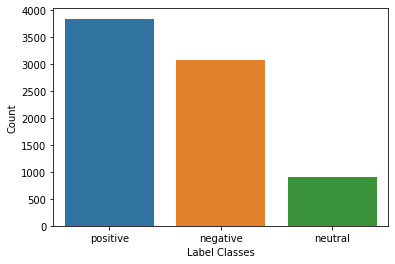

In [10]:
# EDA
count_df = data_dropped[['text','new_sentiment']].groupby('new_sentiment').count().reset_index().rename(columns={'text':'count'})
print(count_df)
print()

ax= plt.subplot()
sns.barplot(x='new_sentiment', y='count', data=count_df); 

# labels, title and ticks
ax.set_xlabel('Label Classes');ax.set_ylabel('Count'); 
ax.xaxis.set_ticklabels(label_type);

# Creating labels

In [11]:
data_dropped['new_sentiment'] = data_dropped['new_sentiment'].apply(lambda x: [x])

one_hot = MultiLabelBinarizer()
labels = one_hot.fit_transform(data_dropped['new_sentiment'].tolist())
labels = pd.DataFrame(labels, columns=one_hot.classes_).reset_index(drop=True)
data_dropped_labels = pd.concat([data_dropped, labels],axis=1).reset_index(drop=True)
label_type = one_hot.classes_
print(label_type)

['negative' 'neutral' 'positive']


In [12]:
df_train, df_test = train_test_split(data_dropped_labels,test_size=0.2,random_state=seed)
df_train.shape, df_test.shape

((6263, 6), (1566, 6))

# Baseline model

In [13]:
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)

X_train_tfidf = tf_idf.fit_transform(df_train["text"].values)
X_test_tfidf = tf_idf.transform(df_test["text"].values)

y_train = df_train["new_sentiment"].apply(lambda x: x[0]).values.tolist()
y_test = df_test["new_sentiment"].apply(lambda x: x[0]).values.tolist()

print("Train size", len(y_train))
print("Test size",len(y_test))

Train size 6263
Test size 1566


In [14]:
%%time
pipeline = Pipeline([
                ('clf', OneVsRestClassifier(XGBClassifier(n_jobs=-1, max_depth=7)))
            ])

pipeline.fit(X_train_tfidf, y_train)

CPU times: user 2min 25s, sys: 163 ms, total: 2min 25s
Wall time: 1min 14s


In [15]:
# evaluate model
model_pred_probs_X_test = pipeline.predict_proba(X_test_tfidf)
model_preds_X_test = pipeline.predict(X_test_tfidf)

#print(len(model_pred_probs_X_test))
#print(len(model_preds_X_test))

print("Accuracy", accuracy_score(y_test,model_preds_X_test))
print("Precision", precision_score(y_test,model_preds_X_test,average="macro"))
print("Recall", recall_score(y_test,model_preds_X_test,average="macro"))
print("F1 Score", f1_score(y_test,model_preds_X_test,average="macro"))

Accuracy 0.5887611749680716
Precision 0.5717260793694993
Recall 0.5033189937609716
F1 Score 0.513210633116269


# Preparing data for BERT

- Find out max_len value to set

In [16]:
max_len = 0
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

for sent in data_dropped['text'].tolist():
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Max sentence length:  95


In [17]:
def bert_preprocess(text_list, seq_len):    
    input_ids = []
    attention_masks = []

    for sent in text_list:
        encoded_sent = tokenizer.encode_plus(
            sent, 
            add_special_tokens=True,        
            max_length=MAX_LEN,             
            pad_to_max_length=True,
            return_attention_mask=True
            #return_tensors='pt')
        
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    return input_ids, attention_masks

In [18]:
MAX_LEN = 95
batch_size = 32

train_text_list = df_train["text"].values
test_text_list = df_test["text"].values

# convert text to id, attention mask, pad
train_input_ids, train_attention_masks = bert_preprocess(train_text_list, seq_len=MAX_LEN)
test_input_ids, test_attention_masks = bert_preprocess(test_text_list, seq_len=MAX_LEN)

# add input ids and attention masks to the dataframe
df_train["features"] = train_input_ids
df_train["masks"] = train_attention_masks
df_test["features"] = test_input_ids
df_test["masks"] = test_attention_masks

# train valid split
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=42)

X_train = df_train["features"].values.tolist()
X_valid = df_valid["features"].values.tolist()

train_masks = df_train["masks"].values.tolist()
valid_masks = df_valid["masks"].values.tolist()

Y_train = df_train[label_type].values.tolist()
Y_valid = df_valid[label_type].values.tolist()

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,
                                sampler=train_sampler,
                                batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                    sampler=validation_sampler,
                                    batch_size=batch_size)

num_labels = len(Y_train[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is

In [19]:
def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
    model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
    checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
                }
    torch.save(checkpoint, save_path)
    return

In [20]:
class BertForSentiment(torch.nn.Module):
    def __init__(self, num_labels=3):
        super(BertForSentiment, self).__init__()
        self.num_labels = num_labels
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels)

        torch.nn.init.xavier_normal_(self.classifier.weight)

    def forward(self, input_ids, attention_mask=None, labels=None):
        last_hidden_state, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask,return_dict=False)
        mean_last_hidden_state = self.pool_hidden_state(last_hidden_state) # pool the output into a mean vector
        pooled_output = self.drop(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            return loss
        else:
            return logits

    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False

    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True

    def pool_hidden_state(self, last_hidden_state):
        mean_last_hidden_state = torch.mean(last_hidden_state, 1)
        return mean_last_hidden_state

In [21]:
model = BertForSentiment(num_labels=num_labels)
model = model.to(device)

num_epochs = 4
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

train_loss_set = valid_loss_set = []
num_train_loss_set = num_valid_loss_set = []

lowest_eval_loss=None
start_epoch=0
loss_fn = nn.CrossEntropyLoss().to(device)
model_save_path = '/content/drive/My Drive/colab_data/bert_sent.model'

In [22]:
for i in trange(num_epochs, desc="Epoch"):

    actual_epoch = start_epoch + i

    # Training
    model.train()

    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for _, batch in enumerate(train_dataloader):
        
        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch

        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        if n_gpu > 1:
            loss = loss.mean()
        
        tr_loss += loss.item()
        num_train_samples += b_labels.size(0)
        
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)
    num_train_loss_set.append(num_train_samples)

    print("\nTrain loss: {}".format(epoch_train_loss))

    # Validation
    model.eval()

    eval_loss = 0
    num_eval_samples = 0

    for batch in validation_dataloader:

        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate validation loss
            loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            if n_gpu > 1:
                loss = loss.mean()
     
            eval_loss += loss.item()
            num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)
    
    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
        lowest_eval_loss = epoch_eval_loss
        save_model(model, model_save_path, actual_epoch, lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
        if epoch_eval_loss < lowest_eval_loss:
            lowest_eval_loss = epoch_eval_loss
            save_model(model, model_save_path, actual_epoch, lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]


Train loss: 0.015747262159745375
Valid loss: 0.012839654970435457


Epoch:  25%|██▌       | 1/4 [01:42<05:07, 102.53s/it]


Train loss: 0.010602401301056563
Valid loss: 0.01159637122276014


Epoch:  50%|█████     | 2/4 [03:24<03:25, 102.50s/it]




Train loss: 0.006519502080129292


Epoch:  75%|███████▌  | 3/4 [05:07<01:42, 102.48s/it]

Valid loss: 0.013614966763749849



Train loss: 0.0039555805097677985


Epoch: 100%|██████████| 4/4 [06:49<00:00, 102.48s/it]

Valid loss: 0.016496465722037997




In [23]:
training_loss_list = []
valid_loss_list = []

for i in range(len(train_loss_set)):
    if i%2 ==0:
        training_loss_list.append(train_loss_set[i])
    else:
        valid_loss_list.append(train_loss_set[i])
print("Train loss:", training_loss_list)
print("Valid loss:", valid_loss_list)

Train loss: [0.015747262159745375, 0.010602401301056563, 0.006519502080129292, 0.0039555805097677985]
Valid loss: [0.012839654970435457, 0.01159637122276014, 0.013614966763749849, 0.016496465722037997]


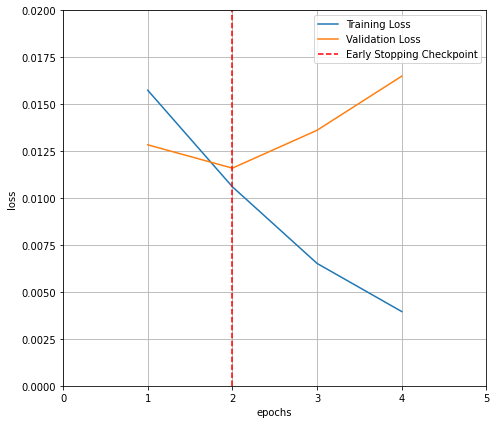

In [33]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(7,6))
plt.plot(range(1,len(training_loss_list)+1),training_loss_list, label='Training Loss')
plt.plot(range(1,len(valid_loss_list)+1),valid_loss_list,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss_list.index(min(valid_loss_list))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.02) # consistent scale
plt.xlim(0, len(training_loss_list)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

# Predict

In [34]:
def bert_predict_proba(model, df, num_labels, device="cpu", batch_size=32):
    num_iter = math.ceil(df.shape[0]/batch_size)
    pred_probs = np.array([]).reshape(0, num_labels)

    model.to(device)
    model.eval()

    for i in range(num_iter):
        df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
        X = df_subset["features"].values.tolist()
        masks = df_subset["masks"].values.tolist()
        X = torch.tensor(X)
        masks = torch.tensor(masks, dtype=torch.long)
        X = X.to(device)
        masks = masks.to(device)
        with torch.no_grad():
            logits = model(input_ids=X, attention_mask=masks)
            logits = logits.sigmoid().detach().cpu().numpy()
            pred_probs = np.vstack([pred_probs, logits])

    return pred_probs

In [35]:
pred_probs = bert_predict_proba(model=model,
                                df=df_test,
                                num_labels=3,
                                device=device,
                                batch_size=32)

print(df_test.shape)
print(len(pred_probs))

(1566, 8)
1566


In [36]:
def predict_one(list_of_prob,label_type):
    model_pred_probs_argmax = np.argmax(list_of_prob, axis=0)
    top_class = label_type[model_pred_probs_argmax]
    return top_class

pred_sent_col = pd.Series(list(map(lambda x: predict_one(x,label_type),pred_probs)))
df_test_ = pd.concat([df_test.reset_index(drop=True),pred_sent_col], axis=1).rename(columns={0:'pred_sent'})

In [37]:
ground_truth_list = df_test['new_sentiment'].apply(lambda x: x[0]).tolist()
print("Accuracy: {}".format(accuracy_score(ground_truth_list, pred_sent_col.tolist())))
print("Precision: {}".format(precision_score(ground_truth_list, pred_sent_col.tolist(), average='macro')))
print("Recall: {}".format(recall_score(ground_truth_list, pred_sent_col.tolist(), average='macro')))
print("F1 Score: {}".format(f1_score(ground_truth_list, pred_sent_col.tolist(), average='macro')))
cm = confusion_matrix(ground_truth_list, pred_sent_col.tolist(),labels=label_type)

Accuracy: 0.7369093231162197
Precision: 0.703805825625834
Recall: 0.7012024162536242
F1 Score: 0.7020096605385163


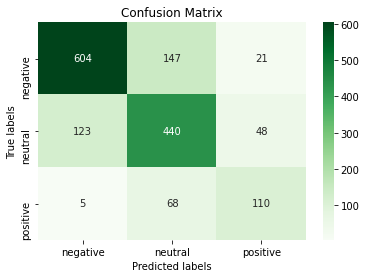

In [38]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens'); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_type); ax.yaxis.set_ticklabels(label_type);
